# Homework 1

We start by importing the packages we will need. Notice that we fix the seed of the random number generator so everyone obtains the same results.

In [1]:
using JuMP
using Cbc
using Random
Random.seed!(2)         # Control random number generation so that we obtain the same scenarios
using LinearAlgebra
using Plots
using Statistics
using Test

We generate the instances at random, given a predefined number of potential suppliers ($i \in I$), demand points ($j \in J$) and time periods ($t \in T$), all parameters are randomly generated.

In [2]:
# This structure will ease the passing of the specific instance for the functions 
# that generate and solve the optimization model.
mutable struct Instance
    nI     # Number of suppliers      
    nJ     # Number of demand points
    nT     # Number of periods
    I      # Supplier range
    J      # Demand points range
    T      # Periods range
    C      # Unit capacity costs per supplier
    H      # Unit storage cost per supplier
    M      # Production cost per supplier
    D      # Client demands in all periods
    Q      # Unit costs of unfulfilled demand
    F      # Unit costs to fulfil demands 
end

## Task 1.1

The function ```solve_deterministic()``` generates and solves the deterministic model. It is good practice to wrap procedures that might be potentially called multiple times in functions. We also consider a keyword argument (following the semicolon) to turn off any printing in the code. However, there is [a bug](https://github.com/jump-dev/Cbc.jl/issues/168) with Cbc causing this parameter to not work.

You are required to complete this function by 
1. Adding the model variables
2. Adding the model objective
3. Adding the model constraints.

Notice that the object ```model``` has been already predefined.

In [3]:
function solve_deterministic(ins::Instance; verbose = true)
    
    ## Renaming for making the implementation clearer
    I = ins.I
    J = ins.J
    T = ins.T 
    C = ins.C
    H = ins.H
    M = ins.M
    D = ins.D
    Q = ins.Q
    F = ins.F
    
    
    model = Model(Cbc.Optimizer)                        # We use Cbc solver

    ## Variables
# TODO: add your code here
    @variables(model, begin
        x[i = I], (lower_bound = 0, base_name = "x(i)")
        k[i = I, t = 0:ins.nT], (lower_bound = 0, base_name = "k(i,t)")
        p[i = I, t = T], (lower_bound = 0, base_name = "p(i,t)")
        e[i = I, j = J, t = T], (lower_bound = 0, base_name = "e(i,j,t)")
        u[j = J, t = T], (lower_bound = 0, base_name = "u(j,t)")
    end)
    fix.(k[I, 0], 0; force = true)
    
    ## Objective: Minimize the total costs
# TODO: add your code here
    @objective(model, Min, 
        sum(C[i]*x[i] for i in I) 
        + sum((H[i]*k[i,t] + M[i]*p[i,t]) for t in T for i in I) 
        + sum(F[i,j]*e[i,j,t] for t in T for j in J for i in I) 
        + sum(Q[j]*u[j,t] for t in T for j in J)
    )

    ## Constraints
# TODO: add your code here
    @constraints(model, begin
        supply_limit[i = I, t = T], p[i,t] <= x[i]
        transition[i = I, t = T], p[i, t] + k[i, t-1] == sum(e[i,j,t] for j in J) + k[i,t]
        demand[j = J, t = T], sum(e[i,j,t] for i in I) == D[j,t] - u[j,t]
    end)
    
    if !verbose
        set_silent(model)                     # Omit solver log
    end
    optimize!(model)                          # Solve the problem
    status = termination_status(model)        # Solution status
    if verbose
        println("Model status = $(status)")   # Print status
    end
    
    return (model,x,p,k,e,u)
end;

In [4]:
## Test data
nI = 5                                 # Number of suppliers      
nJ = 5                                 # Number of demand points
nT = 5                                 # Number of periods
I = 1:nI                               # Supplier range
J = 1:nJ                               # Demand points range
T = 1:nT                               # Periods range

## Generate random data for the problem
C = ones(nI).*5                        # Unit capacity costs per supplier
H = ones(nI).*0.1                      # Unit storage cost per supplier
M = ones(nI)                           # Production cost per supplier

D = zeros(nJ,nT)
for j in J
    for t in T
        D[j,t] = j+0.05*(t-1)          # Client demands in all periods
    end
end

Q = ones(nJ).*50                       # Unit costs of unfulfilled demand

F = zeros(nI,nJ)
for i in I
    for j in J
        F[i,j] = abs(i-j)              # Unit costs to fulfill demands
    end
end

# This packages the problem instance information into a single structure.
test_ins = Instance(nI, nJ, nT, I, J, T, C, H, M, D, Q, F);

In [5]:
(model_det, x_det_test,p_det_test,k_det_test,e_det_test,u_det_test) = solve_deterministic(test_ins, verbose = false)

# @show value.(x_det_test).data
# println(model_det[:supply_limit])
# @show objective_function(model_det)

@test all(value.(x_det_test).data .≈ [1.1; 2.1; 3.1; 4.1; 5.1])

Presolve 70 (-5) rows, 200 (-10) columns and 385 (-15) elements
Perturbing problem by 0.001% of 50 - largest nonzero change 0.00016955053 ( 0.067670863%) - largest zero change 7.4644776e-05
0  Obj 0 Primal inf 77.499975 (25)
35  Obj 88.003632 Primal inf 120.69998 (23)
79  Obj 143.6049 Primal inf 19.199986 (14)
97  Obj 155.26079
Optimal - objective value 155.25
After Postsolve, objective 155.25, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 155.25 - 97 iterations time 0.002, Presolve 0.00


Test Passed
  Expression: all(value.(x_det_test).data .≈ [1.1; 2.1; 3.1; 4.1; 5.1])

## Data generation

We will now generate the data according to the description in task 1.2. We have predefined common growth rate $\mu$ and maximum deviation $\sigma$ to be used in the demand scenario process. The demand is then created as a first-order auto-regressive process. We wrap the process of creating the demand scenarios in the function ```create_scenarios(nS)``` that take as an argument the number of scenarios used ```nS```.

In [6]:
## Generating the demand scenarios
function create_scenarios(ins::Instance, nS)

    ## Renaming for making the implementation clearer
    nJ = ins.nJ
    nT = ins.nT
    J = ins.J
    T = ins.T 
    D = ins.D
    
    S  = 1:nS                 # scenario set
    Ps = repeat([1/nS],nS )   # scenario probability

    ## d_sto: Stochastic demand
    D_sto = zeros(nS, size(D)[1], size(D)[2])    

    ## Creating the Monte Carlo simulation
    α = D[:,1]                           # Initial demand for each node
    μ = 0.05                             # Expected demand growth
    σ = 0.05                             # Max variability
    ϵ = randn(nS,nJ,nT)                  # This is the variability, following a standard normal 

    ## Assigning stochastic values
    for s in S
        for j in J
            D_sto[s,j,1] = (1 + σ * ϵ[s,j,1]) * α[j]
            for t in T[T.>1]
                D_sto[s,j,t] =  (1 + μ + σ * ϵ[s,j,t]) * D_sto[s,j,t-1]
            end
        end
    end
    return D_sto, Ps
end;

## Task 1.2

You are required to complete the function ```solve_stochastic()``` below. 


Just like in Task 1.1, you are required to complete this function by 
1. Adding the model variables
2. Adding the model objective
3. Adding the model constraints.

Notice that the object ```model``` has been already predefined and that the total number of scenarios ```nS``` as well as the probabilities ```Ps``` and demands ```d_sto``` for all scenarios are given as an arguments of the function.

In [7]:
function solve_stochastic(ins::Instance, nS, Ps, D_sto; verbose=true)

    ## Renaming for making the implementation clearer    
    I = ins.I
    J = ins.J
    T = ins.T 
    C = ins.C
    H = ins.H
    M = ins.M
    Q = ins.Q
    F = ins.F
    
    S = 1:nS    # set of scenarios 
    
    model = Model(Cbc.Optimizer)      

    ## Variables
# TODO: add your code here
    # Deterministic Variables
    @variable(model, x[i = I], lower_bound = 0, base_name = "x(i)")

    # Stochasttic Variables
    @variables(model, begin
        k[i = I, t = 0:ins.nT, s = S], (lower_bound = 0, base_name = "k(i,t,s)")
        p[i = I, t = T, s = S], (lower_bound = 0, base_name = "p(i,t,s)")
        e[i = I, j = J, t = T, s = S], (lower_bound = 0, base_name = "e(i,j,t,s)")
        u[j = J, t = T, s = S], (lower_bound = 0, base_name = "u(j,t,s)")
    end)
    fix.(k[I, 0, S], 0; force = true)

    ## Objective: Minimize the total first-stage + second-stage costs over all scenarios
# TODO: add your code here
    # Deterministic objective
    @expression(model, det_cost, sum(C[i]*x[i] for i in I))
    @expression(model, sto_cost, 
        sum(Ps[s]*(
            sum((H[i]*k[i,t,s] + M[i]*p[i,t,s]) for t in T for i in I) + sum(F[i,j]*e[i,j,t,s] for t in T for j in J for i in I) + sum(Q[j]*u[j,t,s] for t in T for j in J)
        ) for s in S)
    )

    @objective(model, Min, det_cost + sto_cost)

    ## Constraints
# TODO: add your code here
    # All constraints are scenario dependent
    @constraints(model, begin
        supply_limit[i = I, t = T, s = S], p[i,t,s] <= x[i]
        transition[i = I, t = T, s = S], p[i, t, s] + k[i, t-1, s] == sum(e[i,j,t,s] for j in J) + k[i,t,s]
        demand[j = J, t = T, s = S], sum(e[i,j,t,s] for i in I) == D_sto[s,j,t] - u[j,t,s]
    end)
    
    if verbose 
        println("Solving stochastic model with $(nS) scenarios...")    
    else
        set_silent(model)                     # Omit solver log
    end
    optimize!(model)                           # Solve the problem

    status = termination_status(model)         # Solution status
    
    if verbose 
        println(status)                        # Print status
    end
    
    return (model,x,p,k,e,u)
end;

In [8]:
# DO NOT create the scenarios (run this cell) more than once or the test below won't work because the randomly generated data is different.
D_sto_test, Ps_test = create_scenarios(test_ins, 10);

In [9]:
(model_sto, x_sto_test, p_sto_test, k_sto_test, e_sto_test, u_sto_test) = solve_stochastic(test_ins, 10, Ps_test, D_sto_test, verbose = false)

# @show value.(x_sto_test).data
# @show objective_function(model_sto)
# println(model_sto[:supply_limit])
# println(latex_formulation(model_sto))

# @test all(round.(value.(x_sto_test).data, digits=2) .≈ [1.11; 2.11; 3.46; 4.65; 6.17]) # Use this for Julia 1.6 and earlier
@test all(round.(value.(x_sto_test).data, digits=2) .≈ [1.12; 2.21; 3.53; 4.51; 5.71]) # Use this for Julia 1.7

Presolve 700 (-50) rows, 1955 (-100) columns and 3850 (-150) elements
Perturbing problem by 0.001% of 5 - largest nonzero change 0.00013140166 ( 0.52397788%) - largest zero change 5.2261156e-05
0  Obj 0 Primal inf 817.93712 (250)
89  Obj 12.576347 Primal inf 909.46571 (254)
178  Obj 35.405295 Primal inf 1126.6545 (266)
267  Obj 66.101783 Primal inf 1021.6759 (254)
356  Obj 88.205712 Primal inf 934.73705 (251)
445  Obj 112.88911 Primal inf 1176.9777 (260)
534  Obj 128.18357 Primal inf 761.31369 (226)
623  Obj 140.18741 Primal inf 379.0311 (199)
712  Obj 151.11633 Primal inf 391.17458 (197)
801  Obj 161.27347 Primal inf 275.66202 (180)
890  Obj 166.65089 Primal inf 344.83621 (150)
965  Obj 168.31148 Primal inf 26.545826 (90)
1046  Obj 168.58658
Optimal - objective value 168.52485
After Postsolve, objective 168.52485, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 168.5248507 - 1046 iterations time 0.012, Presolve 0.00


Test Passed
  Expression: all(round.(value.(x_sto_test).data, digits = 2) .≈ [1.12; 2.21; 3.53; 4.51; 5.71])

## Homework instance

This is the data you are asked to use in you comparisons in Homework 1.2c). The dimensions are considerably larger than in the test instances above.

In [10]:
## Problem data
nI = 25                                # Number of suppliers      
nJ = 25                                # Number of demand points
nT = 10                                # Number of periods
I = 1:nI                               # Supplier range
J = 1:nJ                               # Demand points range
T = 1:nT                               # Periods range

## Generate random data for the problem
C = rand(20:200, nI)                   # Unit capacity costs per supplier
H = rand(1:4, nI)                      # Unit storage cost per supplier
M = rand(10:40, nI)                    # Production cost per supplier
D = repeat(rand(100:500, nJ),1,nT)     # Client demands in all periods
D = (D'.*collect(range(1, step=0.05, length=nT)))' # Adding a trend to demand
Q = rand(5000:10000, nJ)               # Unit costs of unfulfilled demand
F = rand(3:45, (nI,nJ))                # Unit costs to fulfill demands

# This packages the problem instance information into a single structure.
ins = Instance(nI, nJ, nT, I, J, T, C, H, M, D, Q, F);

### Deterministic model

In [11]:
## Solve the deterministic model
(model_det,x_det,p_det,k_det,e_det,u_det) = solve_deterministic(ins, verbose = false);

Presolve 725 (-25) rows, 7000 (-50) columns and 13925 (-75) elements
Perturbing problem by 0.001% of 9795 - largest nonzero change 0.0030372186 ( 0.2935378%) - largest zero change 0
0  Obj 0 Primal inf 94141.25 (250)
89  Obj 110925.92 Primal inf 110881.55 (263)
168  Obj 186301.82 Primal inf 130366.55 (266)
239  Obj 261283.57 Primal inf 146558.05 (265)
314  Obj 467166.31 Primal inf 145073.62 (262)
401  Obj 751933.61 Primal inf 130172.21 (288)
490  Obj 1090505.6 Primal inf 115640.41 (273)
579  Obj 1403898.1 Primal inf 122370.23 (265)
668  Obj 1755401.7 Primal inf 127901.43 (274)
757  Obj 2105641.6 Primal inf 76141.91 (241)
846  Obj 2427480.2 Primal inf 75833.107 (226)
935  Obj 2725764.6 Primal inf 32574.856 (186)
1024  Obj 2847885.7 Primal inf 41225.775 (141)
1113  Obj 2857997 Primal inf 4886.5082 (113)
1202  Obj 2859237.2 Primal inf 6.199943 (57)
1265  Obj 2859253.3
Optimal - objective value 2859086.9
After Postsolve, objective 2859086.9, infeasibilities - dual 0 (0), primal 0 (0)
Optim

In [12]:
xsol_det = value.(x_det)                          # Get optimal x values (reserved capacities)
xsol_det = round.(xsol_det.data, digits = 2)      # Round to 2 decimals 
fval_det = dot(C, xsol_det)                       # Optimal cost of reserved capacities

## Print optimal solution
println("Optimal solution (non-displayed x values are zero):\n")
for i = 1:length(xsol_det)
    if xsol_det[i] > 0.0
        println("x[$(i)] = $(xsol_det[i])")
    end
end

## Print optimal cost of reserved capacities
println("\nOptimal cost of reserved capacities: ", fval_det)

@show sum(xsol_det);

Optimal solution (non-displayed x values are zero):

x[2] = 495.7
x[11] = 3850.6
x[14] = 1355.17
x[17] = 1294.42
x[18] = 400.38
x[20] = 888.25
x[21] = 988.4
x[22] = 391.88
x[23] = 256.5

Optimal cost of reserved capacities: 620974.63
sum(xsol_det) = 9921.3


### Stochastic model
The cell below allows for plotting all the demand profiles (each demand scenario) for a predefined location $i$. You can observe how the demand behave through time and how the variability increases as we look further in the future.

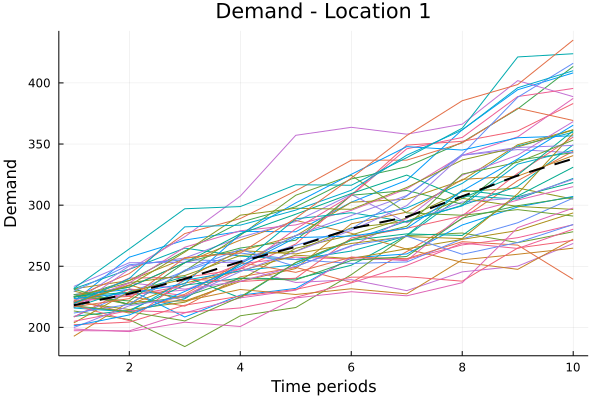

In [13]:
## Considering 50 scenarios for this study
nS = 50
D_sto, Ps = create_scenarios(ins, nS);

## Plotting the scenarios for a single locatiom
location = 1  # selected location for plotting

## Creating empty plot
plt = plot(
    xlabel = "Time periods",
    ylabel = "Demand",  
    title = "Demand - Location $(location)",
    legend = false, fmt = :png
)

## Including each demand series in the plot
for s in 1:nS                                 
    plot!(D_sto[s,location,:], legend = false)
end

## Plotting the expected demand 
plot!(sum(Ps[s]*D_sto[s,location,:] for s in 1:nS), 
    lw = 2,          # line weight
    ls = :dash,      # line stroke
    color = :black, 
    legend = false
)

plt

In [14]:
## Solve the stochastic model
(model_sto, x_sto, p_sto, k_sto, e_sto, u_sto) = solve_stochastic(ins, nS, Ps, D_sto, verbose = false);

Presolve 36250 (-1250) rows, 348775 (-2500) columns and 696250 (-3750) elements
Perturbing problem by 0.001% of 200 - largest nonzero change 0.00094290826 ( 0.75041536%) - largest zero change 0
0  Obj 0 Primal inf 4823693.8 (12500)
406  Obj 23606.803 Primal inf 4860057.8 (12527)
812  Obj 44665.104 Primal inf 4900896.7 (12556)
1218  Obj 63869.097 Primal inf 4934742.3 (12557)
1624  Obj 81774.521 Primal inf 4969458.1 (12567)
2030  Obj 99077.39 Primal inf 5036698.6 (12591)
2436  Obj 116177.86 Primal inf 5047384.9 (12584)
2842  Obj 132028.59 Primal inf 5115674.5 (12570)
3248  Obj 146981.93 Primal inf 5177544.2 (12586)
3654  Obj 162871.06 Primal inf 5245100.5 (12574)
4060  Obj 177293.87 Primal inf 5313934.2 (12584)
4466  Obj 192150.22 Primal inf 5367696.2 (12569)
4872  Obj 208575.85 Primal inf 5326601 (12512)
5278  Obj 226886.51 Primal inf 5327864.8 (12483)
5684  Obj 245927.87 Primal inf 5353071.2 (12458)
6090  Obj 267541.92 Primal inf 5503879.9 (12433)
6496  Obj 287181.53 Primal inf 5519765

In [15]:
xsol_sto = value.(x_sto)                          # Get optimal x values (reserved capacities)
xsol_sto = round.(xsol_sto.data, digits = 2)      # Round to 2 decimals 
fval_sto = dot(C, xsol_sto)                       # Optimal cost of reserved capacities

## Print optimal solution
println("Optimal solution:\n")
for i = 1:length(xsol_sto)
    if xsol_sto[i] > 0.0
        println("x[$(i)] = $(xsol_sto[i])")
    end
end

## Print optimal cost of reserved capacities
println("\nOptimal cost of reserved capacities: ", fval_sto)

@show sum(xsol_sto);

Optimal solution:

x[2] = 499.03
x[11] = 3938.64
x[14] = 1385.36
x[17] = 1390.56
x[18] = 378.79
x[20] = 875.38
x[21] = 1020.73
x[22] = 486.44
x[23] = 262.91

Optimal cost of reserved capacities: 631804.2
sum(xsol_sto) = 10237.839999999998


Notice how the solutions compare in terms of total capacity invested and number of nodes selected as suppliers. Are the capacity centres more centralised or more disperse? Can you think of a reason why (the latter is not relevant for the task, but an interesting thought exercise)? 

We also compare the total time (should be approximately the same as the model solution time) and the allocated memory using the Julia built-in ```@timed``` macro. That is one of the main reasons why we wrapped our model generation and solving into a function.

How do the two models compare in terms of computational requirements?

In [16]:
times_det = []
allocs_det = []
n_sample = 5
for i in 1:n_sample
    stats_det = @timed solve_deterministic(ins, verbose = false);
    push!(times_det, stats_det.time)
    push!(allocs_det, stats_det.bytes)
end
mean_time_det = mean(times_det)
mean_allocs_det = mean(allocs_det)
times_det, allocs_det

Presolve 725 (-25) rows, 7000 (-50) columns and 13925 (-75) elements
Perturbing problem by 0.001% of 9795 - largest nonzero change 0.0030372186 ( 0.2935378%) - largest zero change 0
0  Obj 0 Primal inf 94141.25 (250)
89  Obj 110925.92 Primal inf 110881.55 (263)
168  Obj 186301.82 Primal inf 130366.55 (266)
239  Obj 261283.57 Primal inf 146558.05 (265)
314  Obj 467166.31 Primal inf 145073.62 (262)
401  Obj 751933.61 Primal inf 130172.21 (288)
490  Obj 1090505.6 Primal inf 115640.41 (273)
579  Obj 1403898.1 Primal inf 122370.23 (265)
668  Obj 1755401.7 Primal inf 127901.43 (274)
757  Obj 2105641.6 Primal inf 76141.91 (241)
846  Obj 2427480.2 Primal inf 75833.107 (226)
935  Obj 2725764.6 Primal inf 32574.856 (186)
1024  Obj 2847885.7 Primal inf 41225.775 (141)
1113  Obj 2857997 Primal inf 4886.5082 (113)
1202  Obj 2859237.2 Primal inf 6.199943 (57)
1265  Obj 2859253.3
Optimal - objective value 2859086.9
After Postsolve, objective 2859086.9, infeasibilities - dual 0 (0), primal 0 (0)
Optim

(Any[0.0796555, 0.0823707, 0.0759102, 0.0752982, 0.0815409], Any[34167952, 34167952, 34167952, 34167952, 34167952])

In [17]:
times_sto = []
allocs_sto = []
for i in 1:5
    stats_sto = @timed solve_stochastic(ins, nS, Ps, D_sto, verbose = false);
    push!(times_sto, stats_sto.time)
    push!(allocs_sto, stats_sto.bytes)
end
mean_time_sto = mean(times_sto)
mean_allocs_sto = mean(allocs_sto)
times_sto, allocs_sto

Presolve 36250 (-1250) rows, 348775 (-2500) columns and 696250 (-3750) elements
Perturbing problem by 0.001% of 200 - largest nonzero change 0.00094290826 ( 0.75041536%) - largest zero change 0
0  Obj 0 Primal inf 4823693.8 (12500)
406  Obj 23606.803 Primal inf 4860057.8 (12527)
812  Obj 44665.104 Primal inf 4900896.7 (12556)
1218  Obj 63869.097 Primal inf 4934742.3 (12557)
1624  Obj 81774.521 Primal inf 4969458.1 (12567)
2030  Obj 99077.39 Primal inf 5036698.6 (12591)
2436  Obj 116177.86 Primal inf 5047384.9 (12584)
2842  Obj 132028.59 Primal inf 5115674.5 (12570)
3248  Obj 146981.93 Primal inf 5177544.2 (12586)
3654  Obj 162871.06 Primal inf 5245100.5 (12574)
4060  Obj 177293.87 Primal inf 5313934.2 (12584)
4466  Obj 192150.22 Primal inf 5367696.2 (12569)
4872  Obj 208575.85 Primal inf 5326601 (12512)
5278  Obj 226886.51 Primal inf 5327864.8 (12483)
5684  Obj 245927.87 Primal inf 5353071.2 (12458)
6090  Obj 267541.92 Primal inf 5503879.9 (12433)
6496  Obj 287181.53 Primal inf 5519765

(Any[18.1542363, 21.3485496, 17.5179147, 20.383116, 21.1002926], Any[1809210264, 1816339832, 1816339832, 1816339832, 1816339832])

In [18]:
println("Deterministic model solved in $(mean_time_det) seconds and allocated a total of $(mean_allocs_det/1E6)MB of memory.")
println("Stochastic model solved in $(mean_time_sto) seconds and allocated a total of $(mean_allocs_sto/1E6)MB of memory.")

Deterministic model solved in 0.07895509999999999 seconds and allocated a total of 34.167952MB of memory.
Stochastic model solved in 19.70082184 seconds and allocated a total of 1814.9139184MB of memory.
